In [2]:
# import necessary modules
import raadpy as rp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import to_hex
from matplotlib.ticker import AutoMinorLocator
import numpy as np
import os

%matplotlib widget

In [21]:
# Directory of the buffer
Date= "2022-09-15"


# buffer_fname    = "../Data/Light-1/light1-2022-09-15/light1-2022-09-15-buff1.dat"
buffer_fname    = ("../Data/Light-1/light1-" + Date + "/light1-" + Date + "-buff1.dat")

fname           = buffer_fname.split('/')[-1]

# Decode the buffer data in a dictionary
data_SiPM   = rp.get_dict(buffer_fname,struct=rp.ORBIT_STRUCT,condition="data['id_bit'] == 1")
data_PMT    = rp.get_dict(buffer_fname,struct=rp.ORBIT_STRUCT,condition="data['id_bit'] == 0")
both_det    = rp.get_dict(buffer_fname,struct=rp.ORBIT_STRUCT)

Line:   0%|          | 0/2572 [00:00<?, ?it/s]

Line:   0%|          | 0/2572 [00:00<?, ?it/s]

Line:   0%|          | 0/2572 [00:00<?, ?it/s]

In [ ]:
# print (data_SiPM["scenario"][-1])
# print (data_SiPM)

In [7]:
import raadpy as rp

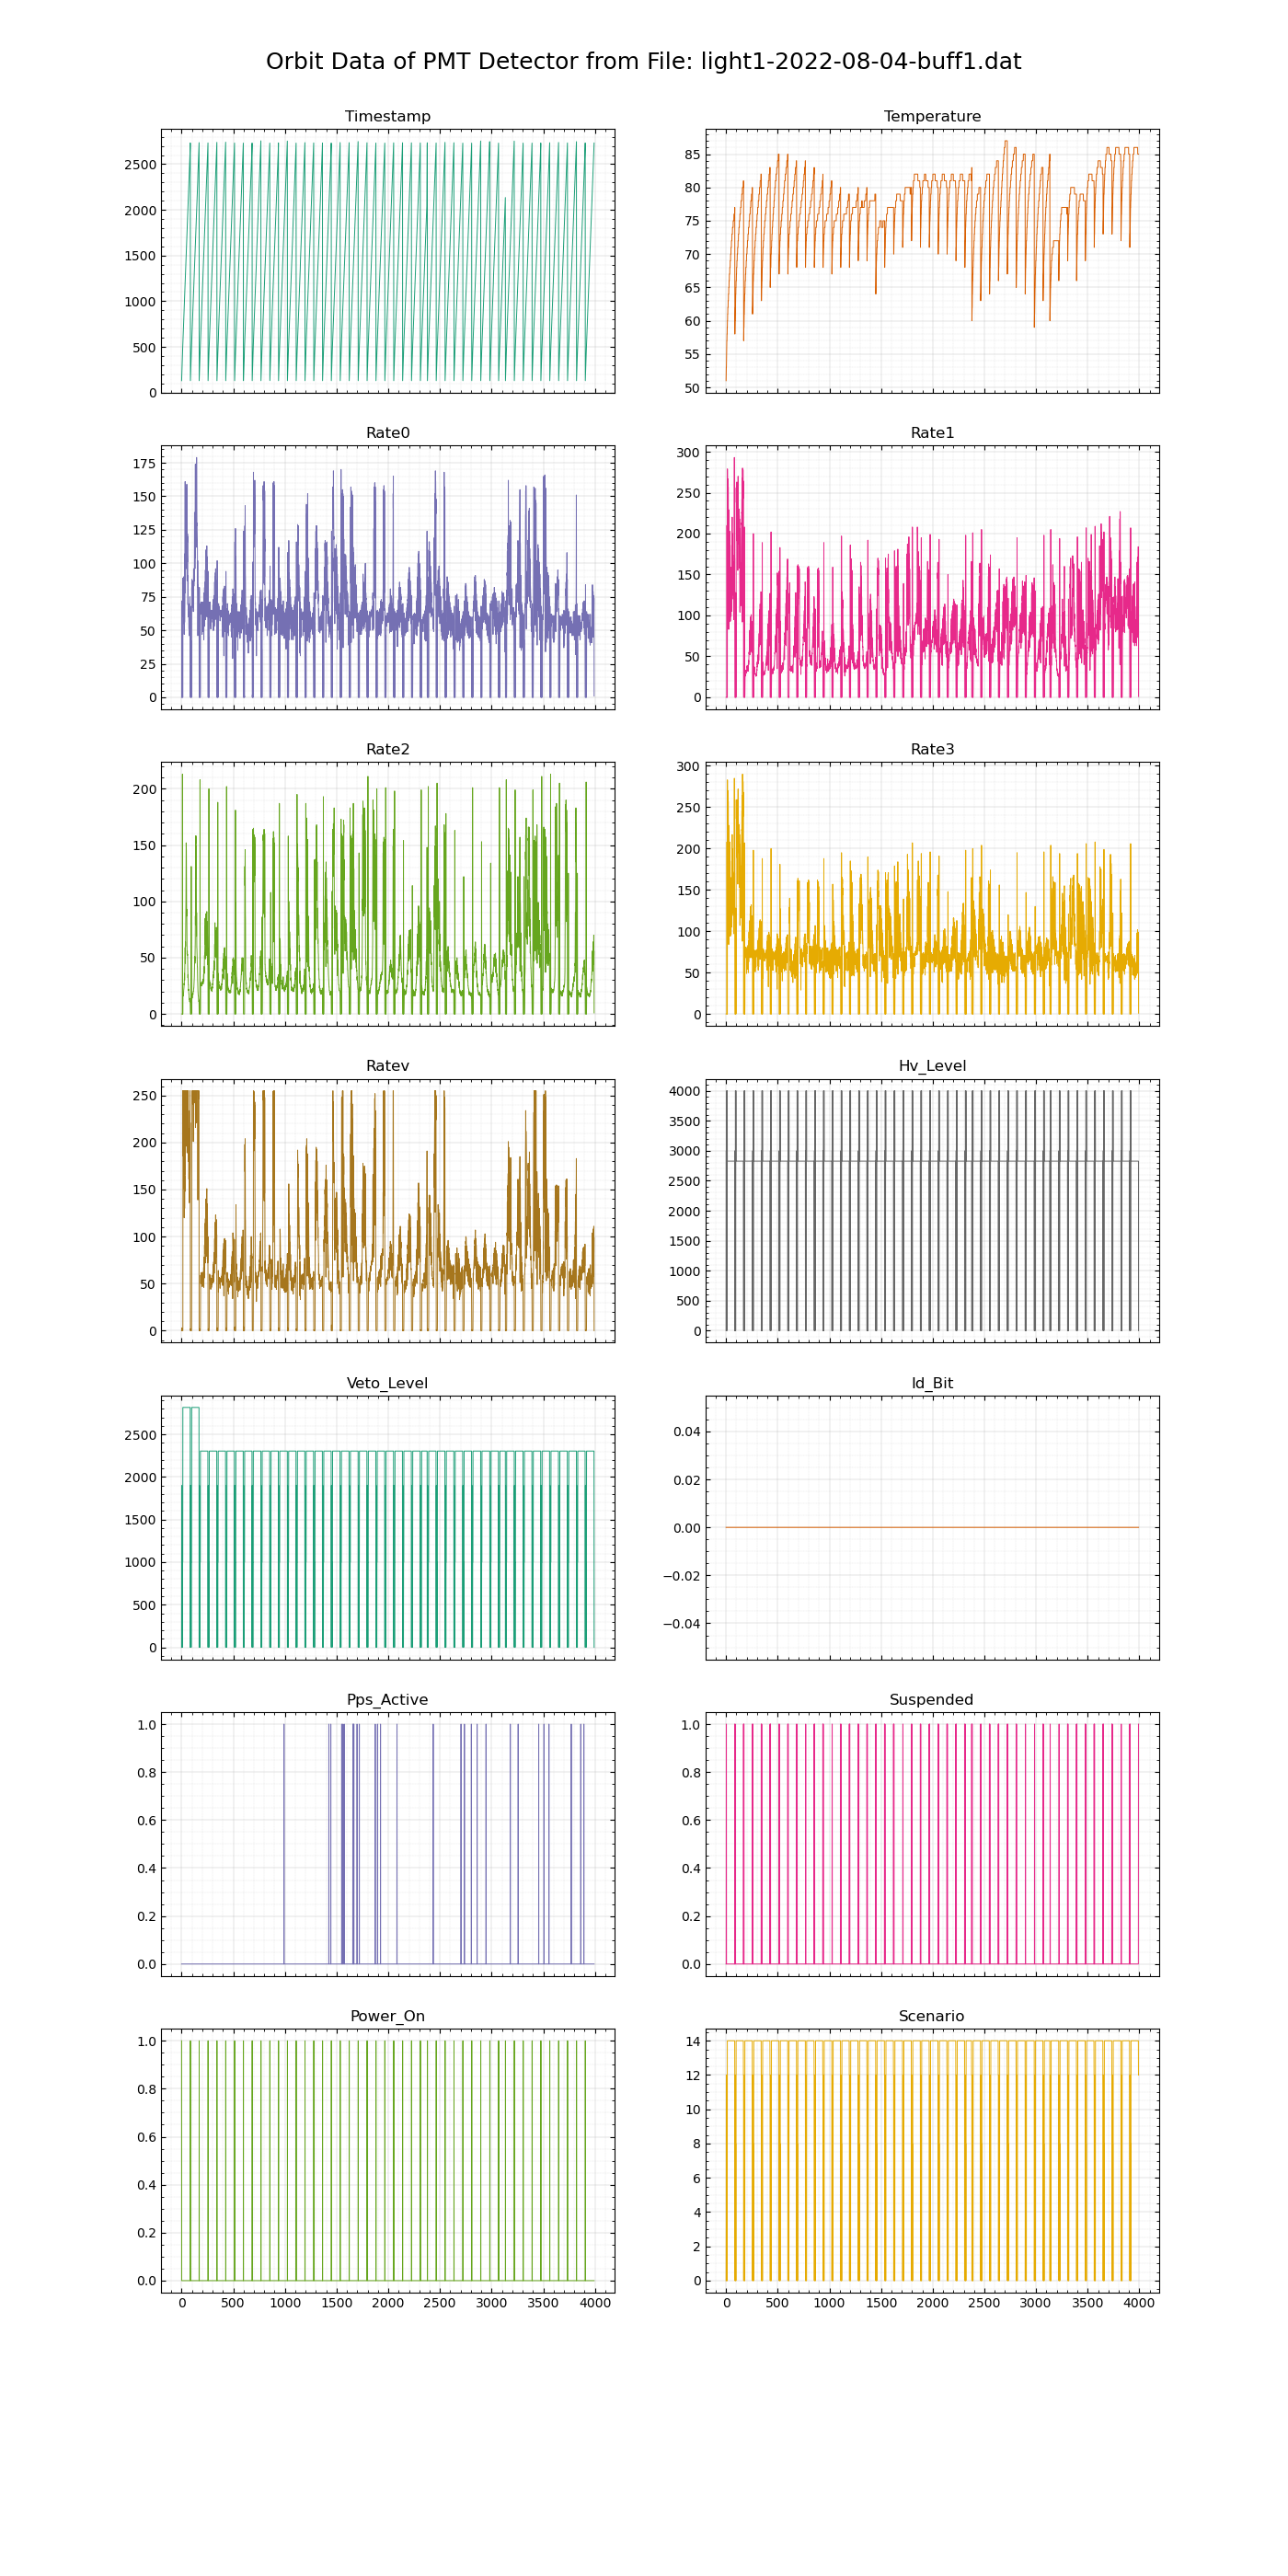

In [14]:
# Now print the PMT Data
# fig1, axes  = rp.plot_buffer(data_PMT,title = 'Orbit Data of PMT Detector from File: '+ fname,UNITS=rp.ORBIT_UNITS)
fig1, axes  = rp.plot_buffer(data_PMT,title = 'Orbit Data of PMT Detector from File: '+ fname)

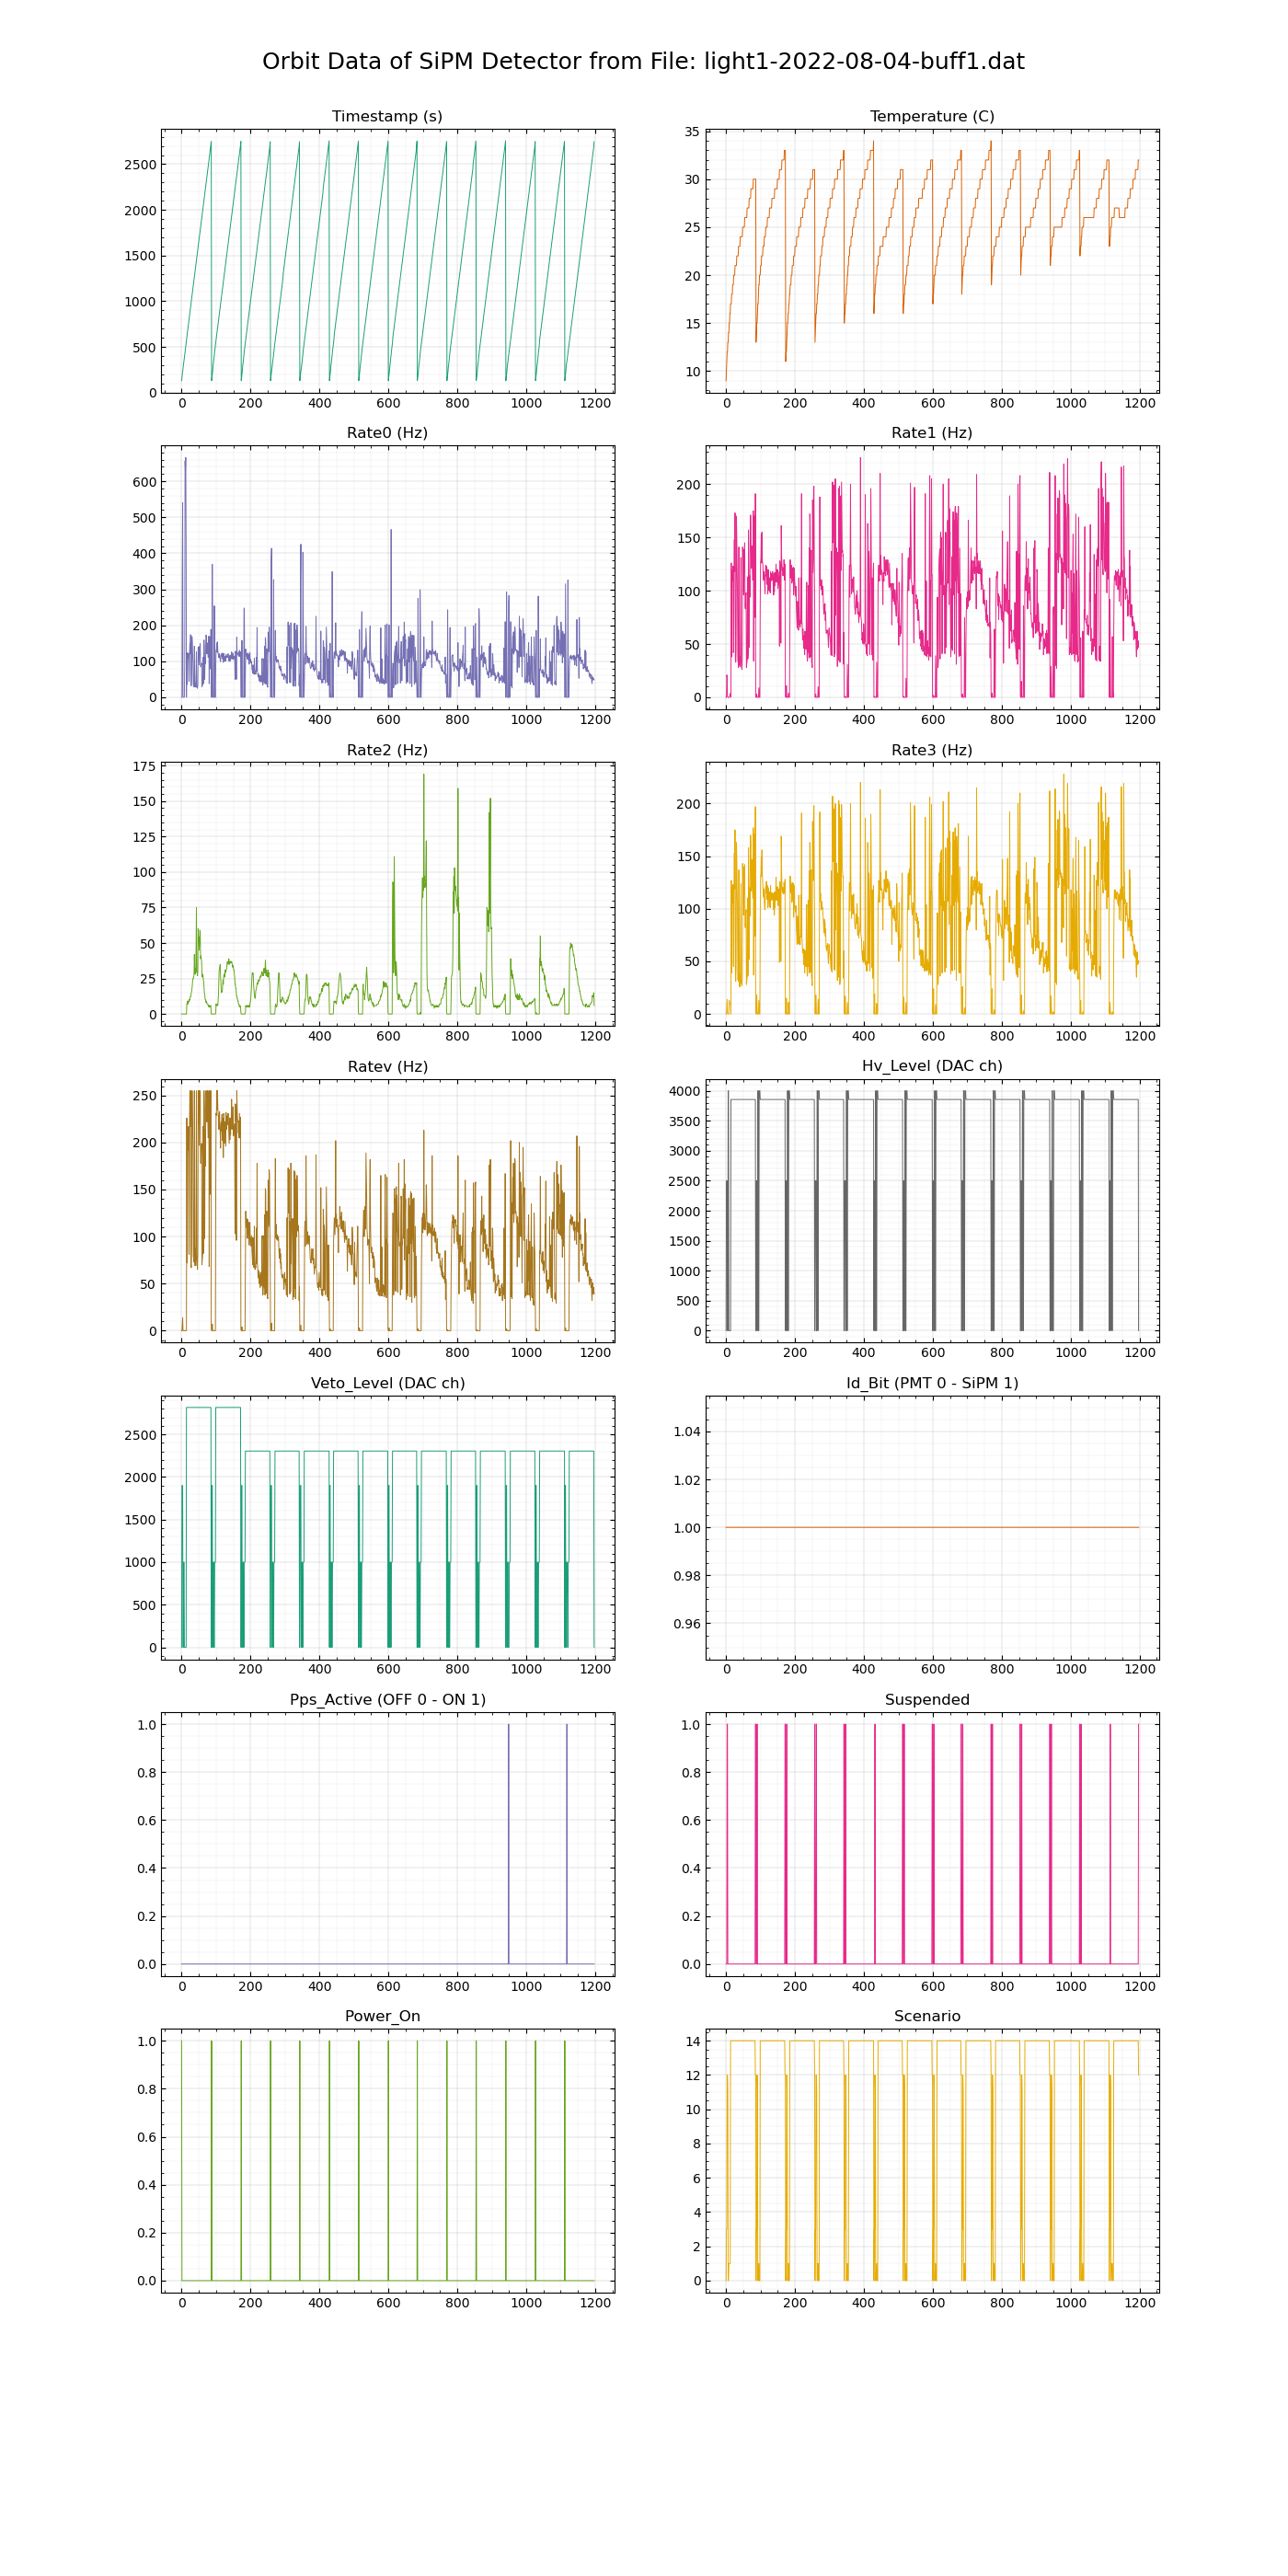

In [ ]:
# Print the SiPM Data
fig2, axes = rp.plot_buffer(data_SiPM, title = 'Orbit Data of SiPM Detector from File: '+ fname,UNITS=rp.ORBIT_UNITS)

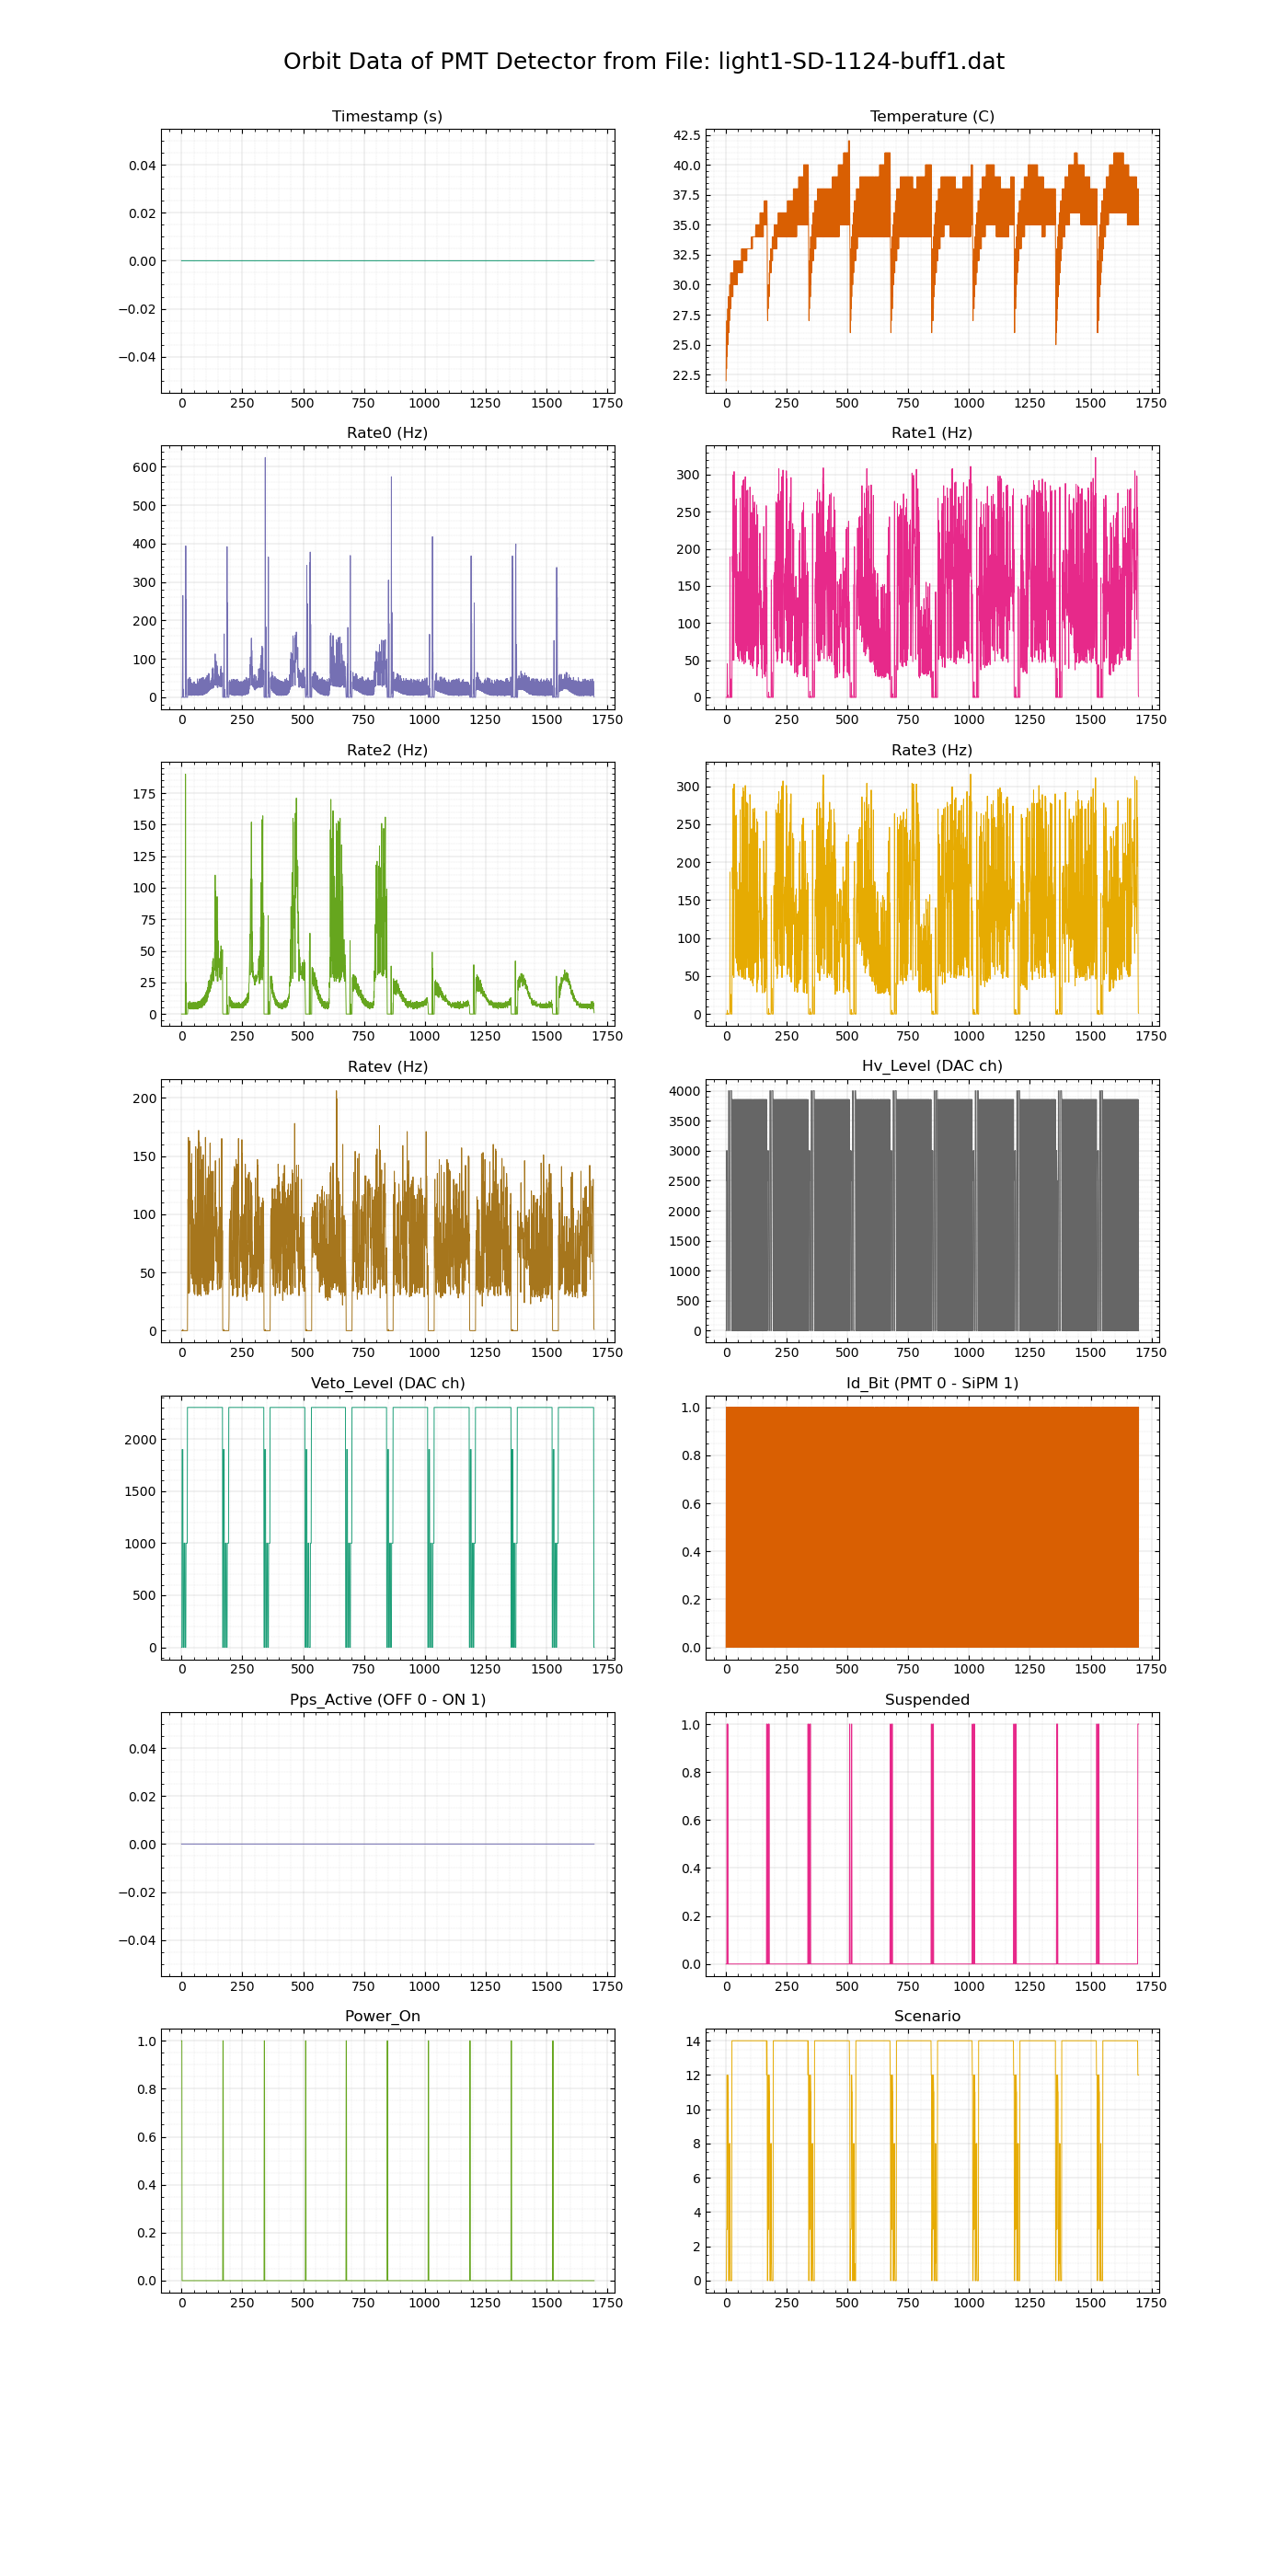

In [ ]:
# Print data of both detectors together
fig10, axes  = rp.plot_buffer(both_det,title = 'Orbit Data of PMT Detector from File: '+ fname,UNITS=rp.ORBIT_UNITS)

In [15]:
# Modified functions
# modified to print the text:

import numpy as np
import pandas as pd
import os
import csv


# Parse a command
def desc_finder(line:str,cmdlist,outputs,i,time,failed_idx):
    """Parse a command and return its status and description

    Args:
        line (str): The string of the command
        cmdlist (pd.DataFrame): pandas data frame with the commands and their equivalent messages
        outputs (_type_): _description_
        i (_type_): _description_
        time (_type_): _description_
        failed_idx (_type_): _description_

    Returns:
        _type_: _description_
    """

    # Get the description
    status = 1
    splt = line.split(' ')

    # define end of log file
    if splt[-1] == 'SE0>':
        desc = 'LOG END'
        desc = [-1,17]
        text = "LOG END"

    # define commands from the command file
    elif 'txrx' in splt[1]:
        node,port,msg = int(splt[2]),int(splt[3]),str(splt[5])

        index = cmdlist.loc[(cmdlist['NODE']==node) & (cmdlist['PORT']==port) & (cmdlist['Message'].str.startswith(msg)),['ID_COMMAND_Proposed','ID_in_Graph']]
        
        # include the power shutdown
        if node == 4:
            index = cmdlist.loc[(cmdlist['NODE']==node) & (cmdlist['PORT']==port),['ID_COMMAND_Proposed','ID_in_Graph']]

        # include the custom scenario
        if port == 9:
            index = cmdlist.loc[(cmdlist['NODE']==node) & (cmdlist['PORT']==port),['ID_COMMAND_Proposed','ID_in_Graph']]

        # include the mysterious command
        if msg in "0F":
            index = cmdlist.loc[(cmdlist['NODE']==node) & (cmdlist['PORT']==port),['ID_COMMAND_Proposed','ID_in_Graph']]

        

        #If index did not find anything
        if len(index) == 0:
            text = ("")
            desc = ("not a payload cmnd ",line)
            
        # if command found in command list
        else:
            desc = list(index.to_numpy()[0])
            text = ("cmnd found in list ",line)
        

        if i in [fid for fid in failed_idx]:
            time = time + (float(splt[4])/1000)
            status = -1
        

    elif splt[1] == 'delay':
        dd   = (float(splt[2])/1000)
        time = time + dd
        ld   =  ("delay of ", dd )
        desc = (ld, line)
        text = ("")

    elif splt[1] == 'delayuntil':
        time = float(splt[2])
        ld =  ("delay until ", time)
        desc = (ld, line)
        text = ("") 

    elif 'read' in splt[1]:
        time = float(outputs[i][0].split(' ')[3])
        desc = ("read the current time ", time, line)
        text = ("")

    else:
        desc = ("unidentified command " , line)
        text = ("")
    
    return desc,time,status,text

# Decode a logfile
# must be automted:
def decode_log(filename:str="../../../Data/Logs/light1-1124v2-se-log.txt"):
    """Take a log file and parse its commands to uncover thier timestamps

    Args:
        filename (str, optional): The filepath and filename of the log file. Defaults to "../../../Data/Logs/light1-SD-1016-se-log.txt".

    Returns:
        _type_: Log, commands, outputs, description, failed_idx, loglines_array
    """

    # Load the logfile
    logfile = open(filename)
    cmdlist = pd.read_csv("command_list_modified.csv")

    # Load the lines
    loglines = logfile.readlines()

    # Close the file
    logfile.close()

    # Create an array with the lines
    commands    = []
    outputs     = []
    idx         = []
    description = []
    times       = []
    fails       = []
    failed_idx  = []
    text_desc   = []

    # Get commands and their indices
    for i, line in enumerate(loglines):
        if 'SE0>' in line:
            commands.append(line)
            idx.append(i)

    # Check if the last command was empty
    if loglines[-1] != 'SE0>':
        commands.append('SE0>')
        idx.append(len(loglines))

    # Get the command output
    for i in range(len(idx)-1):
        out = []
        if 'SE0>#' not in commands[i]:
            for j in range(idx[i]+1,idx[i+1]):
                out.append(loglines[j])
        
        outputs.append(out)

    # Create the dictionary
    log = [[command,output] for command,output in zip(commands,outputs)]

    # Find the commands that failed
    for i in range(len(commands)-1):
        for output in log[i][1]:
            if 'FAIL' in output:
                failed_idx.append(i)


    # Initialize time at 0s
    time = 0
    
    # Give commands and use the finder function to pull the description, time ran, and if the command failed.
    for k, id in enumerate(idx):
        c = commands[k]
        cmd = c.split('\n')[0]
        desc,time,failed,text = desc_finder(cmd,cmdlist,outputs,k,time,failed_idx)

        if len(desc) != 0:
            description.append(desc)
            times.append(time)
            fails.append(failed)
            text_desc.append(text)
    tempname = 'templog.csv'
    fileDir = os.path.join('Defined_Logs')

    if not os.path.exists(fileDir):
        os.makedirs(fileDir)
    
    filePath = os.path.join(fileDir, tempname)

    #Name the headers of the CSV File
    header = ['status','time','description','ID_in_Graph']

    loglines_array = []

    #Clear the file and write from scratch
    with open(filePath, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)

        for i in range(len(description)):
            g = (fails[i], times[i], description[i][0],description[i][1],text_desc[i])
            loglines_array.append(g)
            writer.writerow(g)

    # Return everything else
    return log, commands[:-1], outputs, description, failed_idx, loglines_array


In [16]:
#  Now plot the log file of that date
a,a,a,a,a,loglines_array = decode_log("../Data/Light-1/light1-2022-08-04/light1-2022-08-04-se-log.txt")

pmt_cmds  = [1,2,3,4,5,6,7,8,9,10,11,23,25,27,29,31,33,34,36] 
sipm_cmds = [12,13,14,15,16,17,18,19,20,21,22,24,26,28,30,32,33,35,37]

x_pmt, x_sipm, y_pmt, y_sipm, x_both, y_both, x_failboth, y_failboth, x_pmtfail, y_pmtfail, x_sipmfail, y_sipmfail= [],[],[],[],[],[],[],[],[],[],[],[]

for i in loglines_array:
    if i[0] == 1:

        if (i[2]) in pmt_cmds:
            x_pmt.append(i[1])
            y_pmt.append(i[3])

        if (i[2]) in sipm_cmds:
            x_sipm.append(i[1])
            y_sipm.append(i[3])

        if ((i[2]) in pmt_cmds) or ((i[2]) in sipm_cmds):
            x_both.append(i[1])
            y_both.append(i[3])

    else:
        
        if (i[2]) in pmt_cmds:
            x_pmtfail.append(i[1])
            y_pmtfail.append(i[3])

        if (i[2]) in sipm_cmds:
            x_sipmfail.append(i[1])
            y_sipmfail.append(i[3])

        if ((i[2]) in pmt_cmds) or ((i[2]) in sipm_cmds):
            x_failboth.append(i[1])
            y_failboth.append(i[3])

# fig, axs = plt.subplots(6,figsize=(14,15),sharey=True,sharex=True)
# axs[0].step(x_pmt, y_pmt, where='post')
# axs[0].set_title('PMT - successful excution')
# axs[1].scatter(x_pmtfail, y_pmtfail)
# axs[1].set_title('PMT - Failed')
# axs[2].step(x_sipm, y_sipm, where='post')
# axs[2].set_title('SiPM - successful excution')
# axs[3].scatter(x_sipmfail, y_sipmfail)
# axs[3].set_title('SiPM - Failed')
# axs[4].scatter(x_both,y_both)
# axs[4].set_title('Both - Success')
# axs[5].scatter(x_failboth,y_failboth)
# axs[5].set_title('Both - Failed')

fig, axs = plt.subplots(4,figsize=(16,13),sharey=True,sharex=True)
axs[0].step(x_pmt, y_pmt, where='post')
axs[0].set_title('PMT - successful excution')
axs[1].scatter(x_pmtfail, y_pmtfail)
axs[1].set_title('PMT - Failed')
axs[2].step(x_sipm, y_sipm, where='post')
axs[2].set_title('SiPM - successful excution')
axs[3].scatter(x_sipmfail, y_sipmfail)
axs[3].set_title('SiPM - Failed')


# axs.yaxis.set_minor_locator(AutoMinorLocator())
for ax in range(len(axs)):
    axs[ax].yaxis.set_minor_locator(AutoMinorLocator())
    axs[ax].grid(axis='both', which='major', lw=0.25)
    axs[ax].grid(axis='both', which='minor', lw=0.2, ls=':')



ValueError: invalid literal for int() with base 10: '1rtc'

In [ ]:
# now link data_SiPM["scenario"] with data from logs:

In [ ]:
# Data from the log:

# run once or no?
Array_xpmt= np.array(x_pmt)
Array_ypmt= np.array(y_pmt)
Array_xsipm= np.array(x_sipm)
Array_ysipm= np.array(y_sipm)

# to be used for comparing with scenario:
Array_pmt,Array_pmtx,Array_pmty,Array_pmty0,=[],[],[],[]
Array_sipm,Array_sipmx,Array_sipmy,Array_sipmy0=[],[],[],[]

# Array_pmt.append()??

# We are only looking at the points where the scenario changes
for i in (range(len(Array_ypmt)-1)):
    if Array_ypmt[i] != Array_ypmt[i+1]:
        x = Array_xpmt[i+1]
        y = Array_ypmt[i+1]
        xandy_pmt = (x,y)
        Array_pmt.append(xandy_pmt)
        Array_pmtx.append(x)
        Array_pmty.append(y)
        # print (xandy_pmt)
# print ('...')
# 2022/09/02
for i in (range(len(Array_ysipm)-1)):
    if Array_ysipm[i] != Array_ysipm[i+1]:
        x = Array_xsipm[i+1]
        y = Array_ysipm[i+1]
        xandy_sipm = (x,y)
        Array_sipm.append(xandy_sipm)
        Array_sipmx.append(x)
        Array_sipmy.append(y)
        # print (xandy_sipm)

# replace -1 with 0 (shutdown mode)
for i in Array_pmty:
    if i == -1:
        Array_pmty0.append(0)
    else:
        Array_pmty0.append(i)
        

for i in Array_sipmy:
    if i == -1:
        Array_sipmy0.append(0)
    else:
        Array_sipmy0.append(i)
 

In [ ]:
# Data from the buffer scenario file:

scenariopmt,scenpmtx,scenpmty=[],[],[]
scenariosipm,scensipmx,scensipmy=[],[],[]


for i in range(len(data_PMT["scenario"])-1):
    if data_PMT["scenario"][i] != data_PMT["scenario"][i+1]:
        scen=data_PMT["scenario"][i+1]
        scenariowitheventnumber = (i+1,scen)
        scenariopmt.append(scenariowitheventnumber)
        scenpmtx.append(i+1)
        scenpmty.append(scen)

for i in range(len(data_SiPM["scenario"])-1):
    if data_SiPM["scenario"][i] != data_SiPM["scenario"][i+1]:
        scen=data_SiPM["scenario"][i+1]
        scenariowitheventnumber = (i+1,scen)
        scenariosipm.append(scenariowitheventnumber)
        scensipmx.append(i+1)
        scensipmy.append(scen)



In [ ]:
TSENreplace = []
TSENreplacex= []
TSENreplacey= []

k=0
l=0

for i in range(len(scenpmty)):
    if scenpmty[k] != Array_pmty0[l] :
        k=k+1
    elif scenpmty[k] == Array_pmty0[l]:
        new=(Array_pmtx[l],scenpmtx[k],Array_pmty0[l])
        TSENreplace.append(new)
        TSENreplacex.append(Array_pmtx[l])
        TSENreplacey.append(Array_pmty0[l])
        l=l+1
        k=k+1


# print(TSENreplace)


Text(0.5, 1.0, 'SiPM scen from Buffer 1')

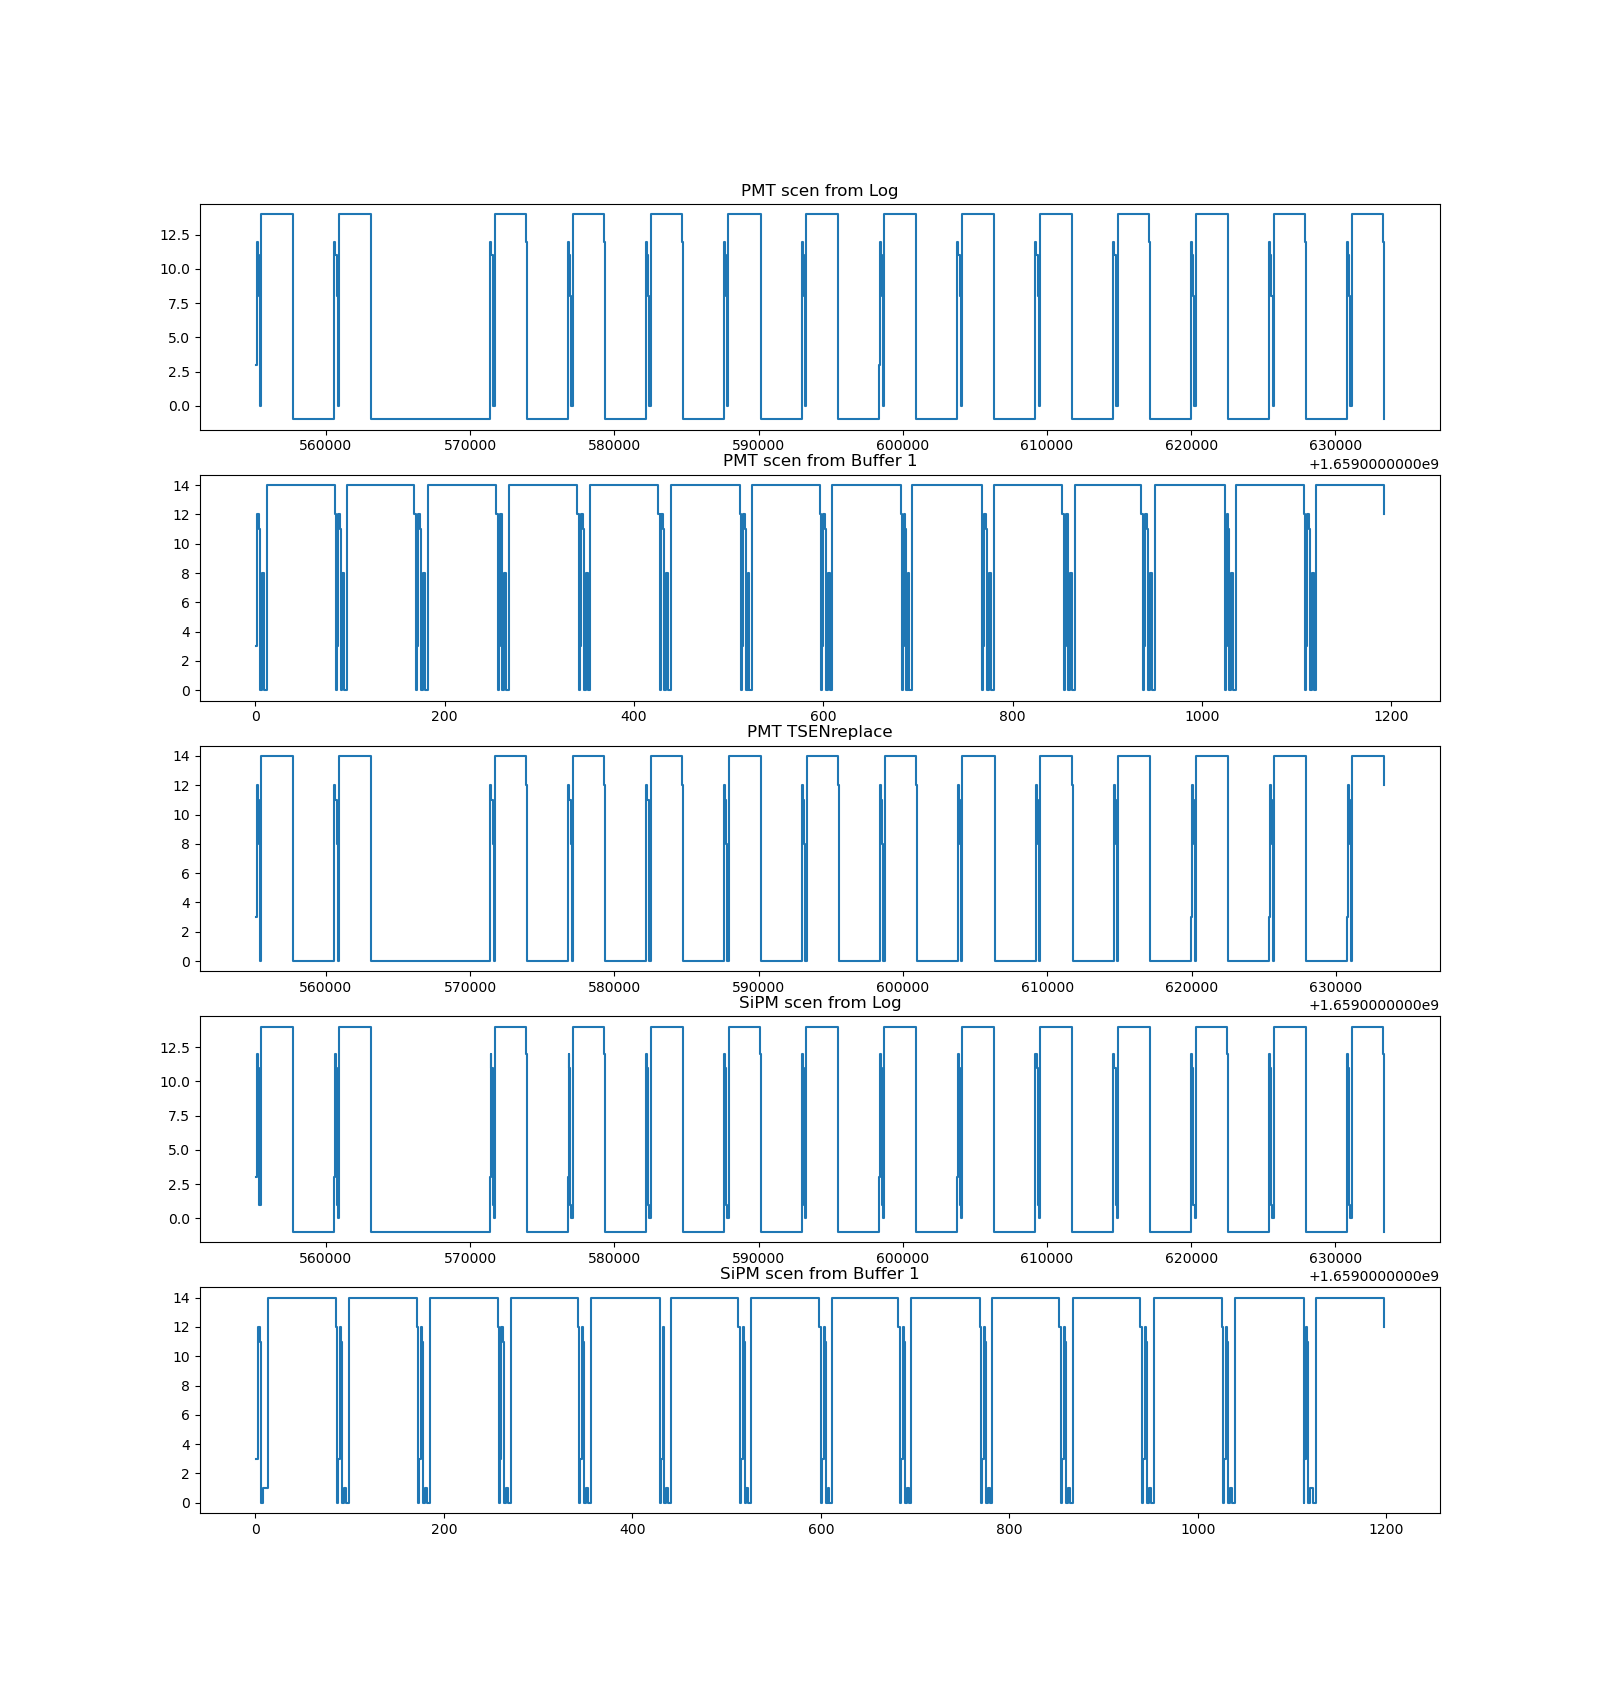

In [ ]:
# plot to check:
fig4, axs = plt.subplots(5,figsize=(16,17))
axs[0].step(Array_pmtx,Array_pmty, where='post')
axs[0].set_title('PMT scen from Log')
axs[1].step(scenpmtx,scenpmty, where='post')
axs[1].set_title('PMT scen from Buffer 1')
axs[2].step(TSENreplacex,TSENreplacey,where='post')
axs[2].set_title('PMT TSENreplace')
axs[3].step(Array_sipmx,Array_sipmy, where='post')
axs[3].set_title('SiPM scen from Log')
axs[4].step(scensipmx,scensipmy, where='post')
axs[4].set_title('SiPM scen from Buffer 1')

# later: step graphs with two x axes? for view only, not priority.

In [ ]:
 print (Array_pmt)

# print (Array_ypmt)
# x_sipm

# print (type(data_SiPM["scenario"]))
# for i in range(len(data_SiPM["scenario"])):
#     Scenario=data_SiPM["scenario"][i]


[(1659555002.015625, -1), (1659555182.015625, 3), (1659555215.021179, 12), (1659555285.027527, 11), (1659555357.034821, 8), (1659555441.038147, 0), (1659555567.539062, 14), (1659557700.00415, 12), (1659560402.013428, -1), (1659560585.013428, 3), (1659560615.019409, 12), (1659560685.0224, 11), (1659560757.025208, 8), (1659560838.028503, 0), (1659560961.531555, 14), (1659563100.004486, 12), (1659571202.009216, -1), (1659571382.009216, 3), (1659571415.016602, 12), (1659571485.018738, 11), (1659571557.02182, 8), (1659571641.026276, 0), (1659571764.528046, 14), (1659573900.003937, 12), (1659576602.016266, -1), (1659576782.016266, 3), (1659576818.035065, 12), (1659576888.037384, 11), (1659576960.040588, 8), (1659577041.043671, 0), (1659577164.546326, 14), (1659579300.000092, 12), (1659582002.00946, -1), (1659582182.00946, 3), (1659582221.015442, 12), (1659582291.017395, 11), (1659582363.019989, 8), (1659582444.023071, 0), (1659582567.526825, 14), (1659584700.003998, 12), (1659587402.007446, 

In [ ]:
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,figsize=(14,10))
# ax1.step(x_pmt,y_pmt,where='post')
# ax2.step(x_sipm,y_sipm,where='post')
# ax3.step(x_both,y_both,where='post')
# ax4.step(x_failboth,y_failboth,where='post')

# ax1.yaxis.set_minor_locator(AutoMinorLocator())
# ax1.grid(axis='both', which='major', lw=0.25)
# ax1.grid(axis='both', which='minor', lw=0.2, ls=':')

# ax2.yaxis.set_minor_locator(AutoMinorLocator())
# ax2.grid(axis='both', which='major', lw=0.25)
# ax2.grid(axis='both', which='minor', lw=0.2, ls=':')

# ax3.yaxis.set_minor_locator(AutoMinorLocator())
# ax3.grid(axis='both', which='major', lw=0.25)
# ax3.grid(axis='both', which='minor', lw=0.2, ls=':')

# ax4.yaxis.set_minor_locator(AutoMinorLocator())
# ax4.grid(axis='both', which='major', lw=0.25)
# ax4.grid(axis='both', which='minor', lw=0.2, ls=':')

# ax3.plot(1,1657859661, 10)
# print(x_pmt)


# fig3 = plt.plot(x,y)
# print (x_pmt,'\n\n',x_sipm)

In [ ]:
a,a,a,a,a,loglines_array = decode_log("../Data/RAW/SD-1124/light1-SD-1124-se-log.txt")

In [ ]:
# down=======================================================================================================================================================

In [ ]:
# Now turn it into a function:

def log_to_time(buffer1_file_location):
    fname = buffer1_file_location.split('/')[-1]
    file  = buffer1_file_location.split('/')[-2]

    # to open the log file
    # ...

    # focus on science first:
    data_SiPM   = rp.get_dict(buffer_fname,struct=rp.ORBIT_STRUCT,condition="data['id_bit'] == 1")
    data_PMT    = rp.get_dict(buffer_fname,struct=rp.ORBIT_STRUCT,condition="data['id_bit'] == 0")

    a,a,a,a,a,loglines_array = decode_log("/home/raad/RAAD/Data/Light-1/light1-2022-08-04-old-old/light1-2022-08-04-se-log.txt") #make it search for the log file itself

    pmt_cmds = [1,2,3,4,5,6,7,8,9,10,11,23,25,27,29,31,33,34,36] 
    sipm_cmds = [12,13,14,15,16,17,18,19,20,21,22,24,26,28,30,32,33,35,37]

    x_pmt, x_sipm, y_pmt, y_sipm, x_both, y_both, x_failboth, y_failboth, x_pmtfail, y_pmtfail, x_sipmfail, y_sipmfail= [],[],[],[],[],[],[],[],[],[],[],[]

    for i in loglines_array:
        if i[0] == 1:

            if (i[2]) in pmt_cmds:
                x_pmt.append(i[1])
                y_pmt.append(i[3])

            if (i[2]) in sipm_cmds:
                x_sipm.append(i[1])
                y_sipm.append(i[3])

            if ((i[2]) in pmt_cmds) or ((i[2]) in sipm_cmds):
                x_both.append(i[1])
                y_both.append(i[3])

        else:
            
            if (i[2]) in pmt_cmds:
                x_pmtfail.append(i[1])
                y_pmtfail.append(i[3])

            if (i[2]) in sipm_cmds:
                x_sipmfail.append(i[1])
                y_sipmfail.append(i[3])

            if ((i[2]) in pmt_cmds) or ((i[2]) in sipm_cmds):
                x_failboth.append(i[1])
                y_failboth.append(i[3])

    Array_xpmt= np.array(x_pmt)
    Array_ypmt= np.array(y_pmt)
    Array_xsipm= np.array(x_sipm)
    Array_ysipm= np.array(y_sipm)

    # to be used for comparing with scenario:
    Array_pmt,Array_pmtx,Array_pmty,Array_pmty0,=[],[],[],[]
    Array_sipm,Array_sipmx,Array_sipmy,Array_sipmy0=[],[],[],[]

    # We are only looking at the points where the scenario changes
    for i in (range(len(Array_ypmt)-1)):
        if Array_ypmt[i] != Array_ypmt[i+1]:
            x = Array_xpmt[i+1]
            y = Array_ypmt[i+1]
            xandy_pmt = (x,y)
            Array_pmt.append(xandy_pmt)
            Array_pmtx.append(x)
            Array_pmty.append(y)
    
    for i in (range(len(Array_ysipm)-1)):
        if Array_ysipm[i] != Array_ysipm[i+1]:
            x = Array_xsipm[i+1]
            y = Array_ysipm[i+1]
            xandy_sipm = (x,y)
            Array_sipm.append(xandy_sipm)
            Array_sipmx.append(x)
            Array_sipmy.append(y)
            
    # replace -1 with 0 (shutdown mode)
    for i in Array_pmty:
        if i == -1:
            Array_pmty0.append(0)
        else:
            Array_pmty0.append(i)
            
    for i in Array_sipmy:
        if i == -1:
            Array_sipmy0.append(0)
        else:
            Array_sipmy0.append(i)
    
    # Data from the buffer scenario file:
    scenariopmt,scenpmtx,scenpmty=[],[],[]
    scenariosipm,scensipmx,scensipmy=[],[],[]

    for i in range(len(data_PMT["scenario"])-1):
        if data_PMT["scenario"][i] != data_PMT["scenario"][i+1]:
            scen=data_PMT["scenario"][i+1]
            scenariowitheventnumber = (i+1,scen)
            scenariopmt.append(scenariowitheventnumber)
            scenpmtx.append(i+1)
            scenpmty.append(scen)

    for i in range(len(data_SiPM["scenario"])-1):
        if data_SiPM["scenario"][i] != data_SiPM["scenario"][i+1]:
            scen=data_SiPM["scenario"][i+1]
            scenariowitheventnumber = (i+1,scen)
            scenariosipm.append(scenariowitheventnumber)
            scensipmx.append(i+1)
            scensipmy.append(scen)

TSENreplace = []
TSENreplacex= []
TSENreplacey= []

k=0
l=0
for i in range(len(scenpmty)):
    if scenpmty[k] != Array_pmty0[l] :
        k=k+1
    elif scenpmty[k] == Array_pmty0[l]:
        new=(Array_pmtx[l],scenpmtx[k],Array_pmty0[l])
        TSENreplace.append(new)
        TSENreplacex.append(Array_pmtx[l])
        TSENreplacey.append(Array_pmty0[l])
        l=l+1
        k=k+1

    return TSENreplace


In [ ]:
# up==================================================================================================================================================

In [ ]:
# Modified functions
# modified to print the text:

import numpy as np
import pandas as pd
import os
import csv

def desc_finder(line:str,cmdlist,outputs,i,time,failed_idx):
    """Parse a command and return its status and description

    Args:
        line (str): The string of the command
        cmdlist (pd.DataFrame): pandas data frame with the commands and their equivalent messages
        outputs (_type_): _description_
        i (_type_): _description_
        time (_type_): _description_
        failed_idx (_type_): _description_

    Returns:
        _type_: _description_
    """

    # Get the description
    status = 1
    splt = line.split(' ')

    # define end of log file
    if splt[-1] == 'SE0>':
        desc = 'LOG END'
        desc = [-1,17]
        text = "LOG END"

    # define commands from the command file
    elif 'txrx' in splt[1]:
        node,port,msg = int(splt[2]),int(splt[3]),str(splt[5])

        index = cmdlist.loc[(cmdlist['NODE']==node) & (cmdlist['PORT']==port) & (cmdlist['Message'].str.startswith(msg)),['ID_COMMAND_Proposed','ID_in_Graph']]
        
        # include the power shutdown
        if node == 4:
            index = cmdlist.loc[(cmdlist['NODE']==node) & (cmdlist['PORT']==port),['ID_COMMAND_Proposed','ID_in_Graph']]

        # include the custom scenario
        if port == 9:
            index = cmdlist.loc[(cmdlist['NODE']==node) & (cmdlist['PORT']==port),['ID_COMMAND_Proposed','ID_in_Graph']]

        # include the mysterious command
        if msg in "0F":
            index = cmdlist.loc[(cmdlist['NODE']==node) & (cmdlist['PORT']==port),['ID_COMMAND_Proposed','ID_in_Graph']]

        

        #If index did not find anything
        if len(index) == 0:
            text = ("")
            desc = ("not a payload cmnd ",line)
            
        # if command found in command list
        else:
            desc = list(index.to_numpy()[0])
            text = ("cmnd found in list ",line)
        

        if i in [fid for fid in failed_idx]:
            time = time + (float(splt[4])/1000)
            status = -1
        

    elif splt[1] == 'delay':
        dd   = (float(splt[2])/1000)
        time = time + dd
        ld   =  ("delay of ", dd )
        desc = (ld, line)
        text = ("")

    elif splt[1] == 'delayuntil':
        time = float(splt[2])
        ld =  ("delay until ", time)
        desc = (ld, line)
        text = ("") 

    elif 'read' in splt[1]:
        time = float(outputs[i][0].split(' ')[3])
        desc = ("read the current time ", time, line)
        text = ("")

    else:
        desc = ("unidentified command " , line)
        text = ("")
    
    return desc,time,status,text

# Decode a logfile
def decode_log(filename:str="../../../Data/Logs/light1-1124v2-se-log.txt"):
    """Take a log file and parse its commands to uncover thier timestamps

    Args:
        filename (str, optional): The filepath and filename of the log file. Defaults to "../../../Data/Logs/light1-SD-1016-se-log.txt".

    Returns:
        _type_: Log, commands, outputs, description, failed_idx, loglines_array
    """

    # Load the logfile
    logfile = open(filename)
    cmdlist = pd.read_csv("command_list_modified.csv")

    # Load the lines
    loglines = logfile.readlines()

    # Close the file
    logfile.close()

    # Create an array with the lines
    commands    = []
    outputs     = []
    idx         = []
    description = []
    times       = []
    fails       = []
    failed_idx  = []
    text_desc   = []

    # Get commands and their indices
    for i, line in enumerate(loglines):
        if 'SE0>' in line:
            commands.append(line)
            idx.append(i)

    # Check if the last command was empty
    if loglines[-1] != 'SE0>':
        commands.append('SE0>')
        idx.append(len(loglines))

    # Get the command output
    for i in range(len(idx)-1):
        out = []
        if 'SE0>#' not in commands[i]:
            for j in range(idx[i]+1,idx[i+1]):
                out.append(loglines[j])
        
        outputs.append(out)

    # Create the dictionary
    log = [[command,output] for command,output in zip(commands,outputs)]

    # Find the commands that failed
    for i in range(len(commands)-1):
        for output in log[i][1]:
            if 'FAIL' in output:
                failed_idx.append(i)


    # Initialize time at 0s
    time = 0
    
    # Give commands and use the finder function to pull the description, time ran, and if the command failed.
    for k, id in enumerate(idx):
        c = commands[k]
        cmd = c.split('\n')[0]
        desc,time,failed,text = desc_finder(cmd,cmdlist,outputs,k,time,failed_idx)

        if len(desc) != 0:
            description.append(desc)
            times.append(time)
            fails.append(failed)
            text_desc.append(text)
    tempname = 'templog.csv'
    fileDir = os.path.join('Defined_Logs')

    if not os.path.exists(fileDir):
        os.makedirs(fileDir)
    
    filePath = os.path.join(fileDir, tempname)

    #Name the headers of the CSV File
    header = ['status','time','description','ID_in_Graph']

    loglines_array = []

    #Clear the file and write from scratch
    with open(filePath, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)

        for i in range(len(description)):
            g = (fails[i], times[i], description[i][0],description[i][1],text_desc[i])
            loglines_array.append(g)
            writer.writerow(g)

    # Return everything else
    return log, commands[:-1], outputs, description, failed_idx, loglines_array


In [1]:
# -------------------------------------------------------------------------------------
# modified after this point

In [ ]:
# The functions:

# Parse a command (command and time)
def desc_finder(line:str,cmdlist,outputs,i,time,failed_idx):
    """Parse a command and return its status and description

    Args:
        line (str): The string of the command
        cmdlist (pd.DataFrame): pandas data frame with the commands and their equivalent messages
        outputs (_type_): _description_
        i (_type_): _description_
        time (_type_): _description_
        failed_idx (_type_): _description_

    Returns:
        _type_: _description_
    """

    # Get the description
    status = 1
    splt = line.split(' ')

    # define end of log file
    if splt[-1] == 'SE0>':
        desc = 'LOG END'
        desc = [-1,17]
        text = "LOG END"

    # define commands from the command file
    elif 'txrx' in splt[1]:
        node,port,msg = int(splt[2]),int(splt[3]),str(splt[5])

        index = cmdlist.loc[(cmdlist['NODE']==node) & (cmdlist['PORT']==port) & (cmdlist['Message'].str.startswith(msg)),['ID_COMMAND_Proposed','ID_in_Graph']]
        
        # include the power shutdown
        if node == 4:
            index = cmdlist.loc[(cmdlist['NODE']==node) & (cmdlist['PORT']==port),['ID_COMMAND_Proposed','ID_in_Graph']]

        # include the custom scenario
        if port == 9:
            index = cmdlist.loc[(cmdlist['NODE']==node) & (cmdlist['PORT']==port),['ID_COMMAND_Proposed','ID_in_Graph']]

        # include the mysterious command
        if msg in "0F":
            index = cmdlist.loc[(cmdlist['NODE']==node) & (cmdlist['PORT']==port),['ID_COMMAND_Proposed','ID_in_Graph']]

        

        #If index did not find anything
        if len(index) == 0:
            text = ("")
            desc = ("not a payload cmnd ",line)
            
        # if command found in command list
        else:
            desc = list(index.to_numpy()[0])
            text = ("cmnd found in list ",line)
        

        if i in [fid for fid in failed_idx]:
            time = time + (float(splt[4])/1000)
            status = -1
        

    elif splt[1] == 'delay':
        dd   = (float(splt[2])/1000)
        time = time + dd
        ld   =  ("delay of ", dd )
        desc = (ld, line)
        text = ("")

    elif splt[1] == 'delayuntil':
        time = float(splt[2])
        ld =  ("delay until ", time)
        desc = (ld, line)
        text = ("") 

    elif 'read' in splt[1]:
        time = float(outputs[i][0].split(' ')[3])
        desc = ("read the current time ", time, line)
        text = ("")

    else:
        desc = ("unidentified command " , line)
        text = ("")
    
    return desc,time,status,text


# Decode a logfile by explaning every command and pinpointing when it happened
def decode_log(filename:str="../Data/Light-1/light1-2022-09-15/light1-2022-09-15-se-log.txt"):
    """Take a log file and parse its commands to uncover thier timestamps

    Args:
        filename (str, optional): The filepath and filename of the log file. Defaults to "../Data/Light-1/light1-2022-09-15/light1-2022-09-15-se-log.txt".

    Returns:
        _type_: Log, commands, outputs, description, failed_idx, loglines_array
    """
    # Identify Date of file:
    date = filename.split('/')[-2][7:]

    # Load the logfile
    logfile = open(filename)
    cmdlist = pd.read_csv("command_list_modified.csv")

    # Load the lines
    loglines = logfile.readlines()

    # Close the file
    logfile.close()

    # Create an array with the lines
    commands    = []
    outputs     = []
    idx         = []
    description = []
    times       = []
    fails       = []
    failed_idx  = []
    text_desc   = []

    # Get commands and their indices
    for i, line in enumerate(loglines):
        if 'SE0>' in line:
            commands.append(line)
            idx.append(i)

    # Check if the last command was empty
    if loglines[-1] != 'SE0>':
        commands.append('SE0>')
        idx.append(len(loglines))

    # Get the command output
    for i in range(len(idx)-1):
        out = []
        if 'SE0>#' not in commands[i]:
            for j in range(idx[i]+1,idx[i+1]):
                out.append(loglines[j])
        
        outputs.append(out)

    # Create the dictionary
    log = [[command,output] for command,output in zip(commands,outputs)]

    # Find the commands that failed
    for i in range(len(commands)-1):
        for output in log[i][1]:
            if 'FAIL' in output:
                failed_idx.append(i)

    # Initialize time at 0s
    time = 0
    
    # Give commands and use the finder function to pull the description, time ran, and if the command failed.
    for k, id in enumerate(idx):
        c = commands[k]
        cmd = c.split('\n')[0]
        desc,time,failed,text = desc_finder(cmd,cmdlist,outputs,k,time,failed_idx)

        if len(desc) != 0:
            description.append(desc)
            times.append(time)
            fails.append(failed)
            text_desc.append(text)
    decoded_file_name = ("Decoded_Logfile_" + date + ".csv")
    fileDir = os.path.join('Defined_Logs')

    if not os.path.exists(fileDir):
        os.makedirs(fileDir)
    
    filePath = os.path.join(fileDir, decoded_file_name)

    #Name the headers of the CSV File
    # header = ['status','time','description','ID_in_Graph']
    header = ["Epoch Time (s)","Detector","CMND # in cmnd list","CMND # in Buff1 Graph"]

    loglines_array = []
    pmt_cmds  = [1,2,3,4,5,6,7,8,9,10,11,23,25,27,29,31,34,36] 
    sipm_cmds = [12,13,14,15,16,17,18,19,20,21,22,24,26,28,30,32,35,37]
    both_cmds = [33]

    #Clear the file and write from scratch
    with open(filePath, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)

        for i in range(len(description)):
            if fails[i] != -1: #Only show commands that were executed successfully
                if len(text_desc[i]) != 0: #Only show the payload cmnds, no time reading cmnds
                    #Sort cmnds by detector:
                    if description[i][0] in pmt_cmds:
                        detector = "PMT"
                    if description[i][0] in sipm_cmds:
                        detector = "SiPM"
                    if description[i][0] in both_cmds:
                        detector = "Both Detectors"
                    if description[i][1] == -1:
                        description[i][1] = 0

                    g = (times[i],detector,description[i][0],description[i][1])
                    loglines_array.append(g)
                    writer.writerow(g)

    # Return everything else
    return log, commands[:-1], outputs, description, failed_idx, loglines_array


In [ ]:
# Choose date and run the code:

Date= "2022-09-15"
a,a,a,a,a,loglines_array = decode_log("../Data/Light-1/light1-" + Date + "/light1-" + Date + "-se-log.txt")


In [ ]:
#  now a function you give time to and it gives you the cenario

def time_from_log (loglines_array,time):
    for i in range(len(loglines_array)):
        if loglines_array[i][0] != loglines_array[i+1][0]:
            if loglines_array[i][0] < time < loglines_array[i+1][0]:

                # if detector in loglines_array[i][1]:

                text = ("Between time " + str(loglines_array[i][0]) + " and time " + str(loglines_array[i+1][0]) + " " + str(loglines_array[i][1]) + " in scenario " + str(loglines_array[i][3]))
                print (text)
            
    # return text 
    
    # between this time and this time

In [ ]:
time_from_log(loglines_array,1663200287.973054)